# Homework 2023, Week 1

In [52]:
%run init_notebook.py

Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt

Watermark:
----------
Last updated: 2024-03-21T01:41:07.663921-05:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.15.0

Compiler    : Clang 15.0.7 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

pandas     : 2.1.0
scipy      : 1.11.2
pymc       : 5.8.0
xarray     : 2023.8.0
numpy      : 1.25.2
arviz      : 0.16.1
matplotlib : 3.7.2
statsmodels: 0.14.0



### 1. Suppose the globe tossing data (Lecture 2, Chapter 2) had turned out to be 4 water and 11 land. Construct the posterior distribution.

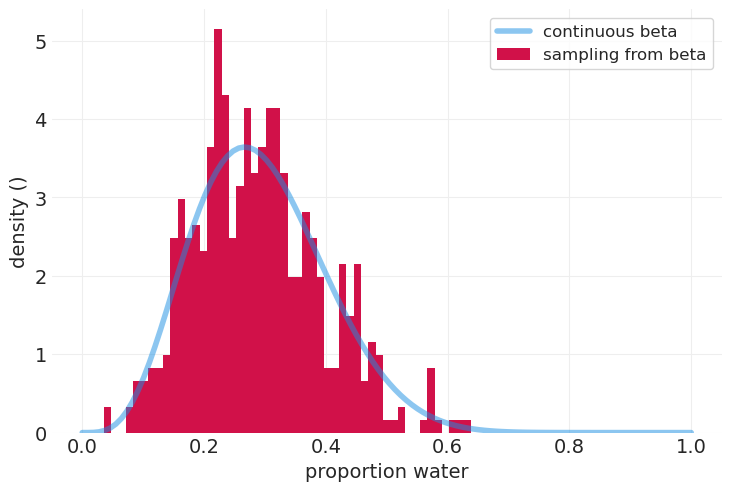

In [145]:
# Given the sample in N = 15 tosses
sample = 4*"W" + 11*"L"

def count_proportion(sample: str):  # breaking down num of W and L in given sample
    nW = len(sample.replace("L", ""))
    nL = len(sample) - nW
    return nW, nL

nW, nL = count_proportion(sample)  # extracting number of W and L in sample


# Assuming infinite possibilities of faces, globe tossing data would follow the beta distribution
# Manual computation of the idealized beta distribution
from scipy.special import factorial
def beta(sample: str, p):
    nW, nL = count_proportion(sample)
    posteriorP = factorial(nW + nL + 1) / (factorial(nW) * factorial(nL)) * p**nW * (1-p)**nL
    return posteriorP

pWater = np.linspace(0, 1, 110)  # Given that there are inf faces, will will select a set of proportions of face with water for input into beta
posteriorP = beta(sample, pWater)

# Using scipy to create beta distr obj, useful for sampling from
posteriorBeta = stats.beta(nW+1, nL+1)
posteriorBeta_samples = posteriorBeta.rvs(500)  # sampling for pWater, frequency follows that of the pdf

# Graph posterior distribution: prob(p | W, L) <- p
plt.plot(pWater, posteriorP, color=color, linewidth=4, alpha=.5, label='continuous beta')
plt.hist(posteriorBeta_samples, bins=50, density=True, label='sampling from beta');
plt.xlabel("proportion water")
plt.ylabel("density ()")
plt.legend();

### 2. Using the posterior distribution from 1, compute the posterior predictive distribution for the next 5 tosses of the same globe. I recommend you use the sampling method.

Text(0, 0.5, 'density')

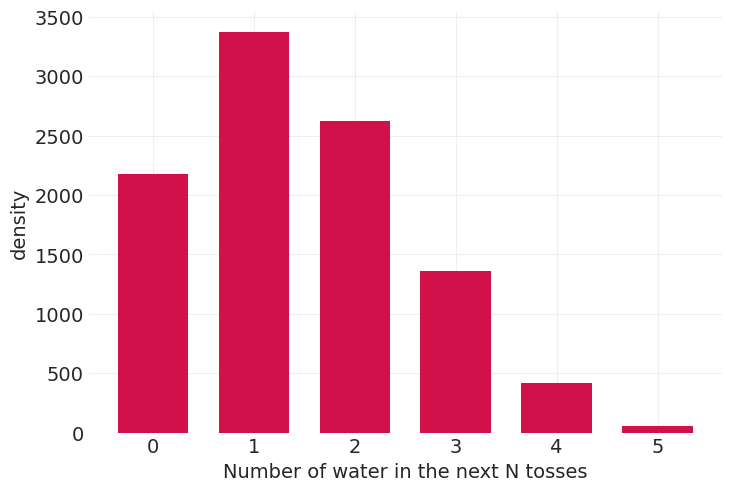

In [152]:
# Sampling from the posterior to attain p values, weighted by the freq at which they were sampled
# Use p to simulate toss of N times
def simulate_toss(p, N):
    sample = np.random.choice(list("WL"),  size=N, p=np.array([p, 1-p]), replace=True)
    sample = ''.join(sample)
    nW, nL = count_proportion(sample)
    return nW

N = 5;  # Next 5 tosses
posteriorBeta_sampled_p = posteriorBeta.rvs(10000)
posterior_predictive_distribution = [simulate_toss(p, N) for p in posteriorBeta_sampled_p]

# Graph posterior predictive distribution: 
plt.hist(posterior_predictive_distribution, bins=range(0,7), align='left', rwidth=.7)
plt.xlabel("Number of water in the next N tosses")
plt.ylabel("density")

### 3. Use the posterior predictive distribution from 2 to calculate the probability of 3 or more water samples in the next 5 tosses.

In [154]:
# Prob of W>= 3 in N=5 is Prob (W = 3 or 4 or 5)
posterior_predictive_distribution_array = np.array(posterior_predictive_distribution)

pW = ((posterior_predictive_distribution_array) >= 3).sum() / len(posterior_predictive_distribution_array)

print(pW)

0.1826


### 4. OPTIONAL Challenge: Suppose you observe W = 5 water points, but you forgot to write down how many times the globe was tossed, so you don’t know the number of land points L. Assume that p = 0.7 and compute the posterior distribution of the number of tosses N. Hint: Use the binomial distribution.

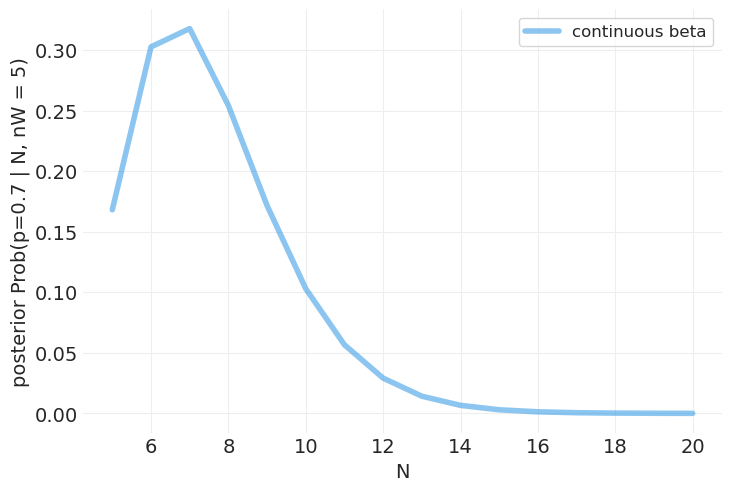

In [185]:
# Assuming that posterior Prob (p=0.7 | W=5, N) -> follow a binomial distribution
# N is >= 5 tosses; it can be inf, but we will lim to N=20 tosses for this computation
def posteriorP_unknownN(nw, p):
    N = np.arange(nW, 21, 1)
    binom_coef = factorial(N) / (factorial(nW) * factorial(N-nW))
    posteriorP_Binom = binom_coef * p**nW * (1-p)**(N-nW)
    return N, posteriorP_Binom


nW=5;
p=0.7;
N, posteriorP_Binom = posteriorP_unknownN(nW, p)

plt.plot(N, posteriorP_Binom , color=color, linewidth=4, alpha=.5, label='continuous beta')
plt.xlabel("N")
plt.ylabel("posterior Prob(p=0.7 | N, nW = 5)")
plt.legend();